In [ ]:
#@title License
# Copyright 2022 The Pix2Seq Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

## Pix2seq: A Language Modeling Framework for Object Detection
<a href="https://colab.research.google.com/github/google-research/pix2seq/blob/master/colabs/pix2seq_finetuning_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This colab presents a demo for object detection fine-tuning with Pix2seq. The table below provides a summary and model location for pretrained models on Objects365 dataset, which can be used as initializations for fine-tuning.

Backbone       | Total params (M) | Image size | Google cloud storage location
-------------: | ---------------: | ---------: | -----------:
ResNet-50      | 36.6             | 640x640    | [gs://pix2seq/obj365_pretrain/resnet_640x640_b256_s400k](https://console.cloud.google.com/storage/browser/pix2seq/obj365_pretrain/resnet_640x640_b256_s400k)
ResNet-50 (C4) | 84.7             | 640x640    | [gs://pix2seq/obj365_pretrain/resnetc_640x640_b256_s400k](https://console.cloud.google.com/storage/browser/pix2seq/obj365_pretrain/resnetc_640x640_b256_s400k)
ViT-L          | 115.2            | 640x640    | [gs://pix2seq/obj365_pretrain/vit_b_640x640_b256_s400k](https://console.cloud.google.com/storage/browser/pix2seq/obj365_pretrain/vit_b_640x640_b256_s400k)
ViT-B          | 341.2            | 640x640    | [gs://pix2seq/obj365_pretrain/vit_l_640x640_b256_s400k](https://console.cloud.google.com/storage/browser/pix2seq/obj365_pretrain/vit_l_640x640_b256_s400k)


In [ ]:
# pip installs.
!pip install ml_collections
!pip install tensorflow-addons
!git clone https://github.com/google/pix2seq.git

import os, sys

sys.path.append(os.getcwd())
root_dir = os.getcwd()
sys.path.insert(1, 'pix2seq')

     |████████████████████████████████| 77 kB 3.2 MB/s 
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94524 sha256=47e9ea97ef4e7bc50fa5c9b8a7ef7b3828c9500794d34abb83d74e94cbd283b4
  Stored in directory: /root/.cache/pip/wheels/b7/da/64/33c926a1b10ff19791081b705879561b715a8341a856a3bbd2
Successfully built ml-collections
     |████████████████████████████████| 1.1 MB 4.8 MB/s 
Cloning into 'pix2seq'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 70 (delta 24), reused 63 (delta 17), pack-reused 0
Unpacking objects: 100% (70/70), done.


In [ ]:
# Imports.
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import requests
import json

import ml_collections
import utils
from data.dataset import Dataset
from models import model as model_lib
from models import ar_model
from tasks import task as task_lib
from tasks import object_detection

In [ ]:
# Define a Dataset class to use for finetuning.
class VocDataset(Dataset):

  def extract(self, example, training):
    """Extracts needed features & annotations into a flat dictionary.

    Note: be consisous about 0 in label, which should probably reserved for
       special use (such as padding).

    Args:
      example: `dict` of raw features.
      training: `bool` of training vs eval mode.

    Returns:
      example: `dict` of relevant features and labels
    """
    # These features are needed by the object detection task.
    features = {
        'image': tf.image.convert_image_dtype(example['image'], tf.float32),
        'image/id': 0, # dummy int.
    }

    # The following labels are needed by the object detection task.
    label = example['objects']['label'] + 1  # 0 is reserved for padding.
    bbox = example['objects']['bbox']

    # Use tf.numpy_function to get features not easily computed in tf.
    def get_area(bboxes):
      return np.asarray([
          (b[2] - b[0]) * (b[3] - b[1]) for b in bboxes], dtype=np.int32)

    areas = tf.numpy_function(get_area, (bbox,), (tf.int32,))
    areas = tf.reshape(areas, [tf.shape(label)[0]])

    labels = {
        'label': label,
        'bbox': bbox,
        'area': areas,
        'is_crowd': tf.zeros_like(label, tf.bool),
    }
    return features, labels

In [ ]:
# Load config for the pretrained model.
pretrained_model_dir = 'gs://pix2seq/obj365_pretrain/resnet_640x640_b256_s400k/'
with tf.io.gfile.GFile(os.path.join(pretrained_model_dir, 'config.json'), 'r') as f:
  config = ml_collections.ConfigDict(json.loads(f.read()))

# Update config for finetuning (some configs were missing at initial pretraining time).
config.dataset.tfds_name = 'voc'
config.dataset.batch_duplicates = 1
config.dataset.coco_annotations_dir = None
config.task.name == 'object_detection'
config.task.vocab_id = 10  # object_detection task vocab id.
config.task.weight = 1.
config.task.max_instances_per_image_test = 10
config.tasks = [config.task]
config.train.batch_size = 8
config.model.name = 'encoder_ar_decoder'  # name of model and trainer in registries.
config.model.pretrained_ckpt = pretrained_model_dir
config.optimization.learning_rate = 1e-4
config.optimization.warmup_steps = 10

# Use a smaller image_size to speed up finetuning here.
# You can use any image_size of choice.
config.model.image_size = 320
config.task.image_size = 320

In [ ]:
# Perform training for 1000 steps. This takes about ~20 minutes on a regular Colab GPU.
train_steps = 1000
use_tpu = False  # Set this accordingly.
steps_per_loop = 10
tf.config.run_functions_eagerly(False)

strategy = utils.build_strategy(use_tpu=use_tpu, master='')

# The following snippets are mostly copied and simplified from run.py.
with strategy.scope():
  # Get dataset.
  dataset = VocDataset(config)

  # Get task.
  task = task_lib.TaskRegistry.lookup(config.task.name)(config)
  tasks = [task]

  # Create tf.data.Dataset.
  ds = dataset.pipeline(
      process_single_example=task.preprocess_single,
      global_batch_size=config.train.batch_size,
      training=True)
  datasets = [ds]
  
  # Setup training elements.
  trainer = model_lib.TrainerRegistry.lookup(config.model.name)(
      config, model_dir='model_dir',
      num_train_examples=dataset.num_train_examples, train_steps=train_steps)
  data_iterators = [iter(dataset) for dataset in datasets]

  @tf.function
  def train_multiple_steps(data_iterators, tasks):
    train_step = lambda xs, ts=tasks: trainer.train_step(xs, ts, strategy)
    for _ in tf.range(steps_per_loop):  # using tf.range prevents unroll.
      with tf.name_scope(''):  # prevent `while_` prefix for variable names.
        strategy.run(train_step, ([next(it) for it in data_iterators],))

  global_step = trainer.optimizer.iterations
  cur_step = global_step.numpy()
  while cur_step < train_steps:
    train_multiple_steps(data_iterators, tasks)
    cur_step = global_step.numpy()
    print(f"Done training {cur_step} steps.")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/voc/2007/4.0.0.incompleteZYE1NB/voc-test.tfrecord


  0%|          | 0/4952 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/voc/2007/4.0.0.incompleteZYE1NB/voc-train.tfrecord


  0%|          | 0/2501 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/voc/2007/4.0.0.incompleteZYE1NB/voc-validation.tfrecord


  0%|          | 0/2510 [00:00<?, ? examples/s]

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Done training 10 steps.
Done training 20 steps.
Done training 30 steps.
Done training 40 steps.
Done training 50 steps.
Done training 60 steps.
Done training 70 steps.
Done training 80 steps.
Done training 90 steps.
Done training 100 steps.
Done training 110 steps.
Done training 120 steps.
Done training 130 steps.
Done training 140 steps.
Done training 150 steps.
Done training 160 steps.
Done training 170 steps.
Done training 180 steps.
Done training 190 steps.
Done training 200 steps.
Done training 210 steps.
Done training 220 steps.
Done training 230 steps.
Done training 240 steps.
Done training 250 steps.
Done training 260 steps.
Done training 270 steps.
Done training 280 steps.
Done training 290 steps.
Done training 300 steps.
Done training 310 steps.
Done training 320 steps.
Done training 330 steps.
Done training 340 steps.
Done training 350 steps.
Done training 360 steps.
Done training 370 steps.
Done training 380 steps.
Done training 390 steps.
Done training 400 steps.
Done trai

In [ ]:
# Run one step of inference (on the training set).

# Set category names in task for visualization.
# The category names for COCO are picked up from the coco annotation files. For
# other datasets, they can be added manually in the code. If they are missing,
# the visualization will not contain category names for predicted boxes, but
# no other things will be impacted.
category_names = [
    'Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle', 'Bus', 'Car', 'Cat',
    'Chair', 'Cow', 'Dining table', 'Dog', 'Horse', 'Motorbike', 'People',
    'Potted plant', 'Sheep', 'Sofa', 'Train', 'TV/monitor']
task._category_names = {
    i + 1 : {'name': name} for i, name in enumerate(category_names)}

def single_step(examples):
  preprocessed_outputs = task.preprocess_batched(examples, training=False)
  infer_outputs = task.infer(trainer.model, preprocessed_outputs)
  return task.postprocess_tpu(*infer_outputs)

with strategy.scope():
  @tf.function
  def run_single_step(iterator):
    examples = next(iterator)
    outputs = strategy.run(single_step, (examples,))
    if outputs is not None:
      outputs = [strategy.gather(t, axis=0) for t in outputs]
    return outputs

  iterator = iter(ds)
  per_step_outputs = run_single_step(iterator)
  vis = task.postprocess_cpu(
      per_step_outputs,
      train_step=100,
      eval_step=0,
      ret_results=True)

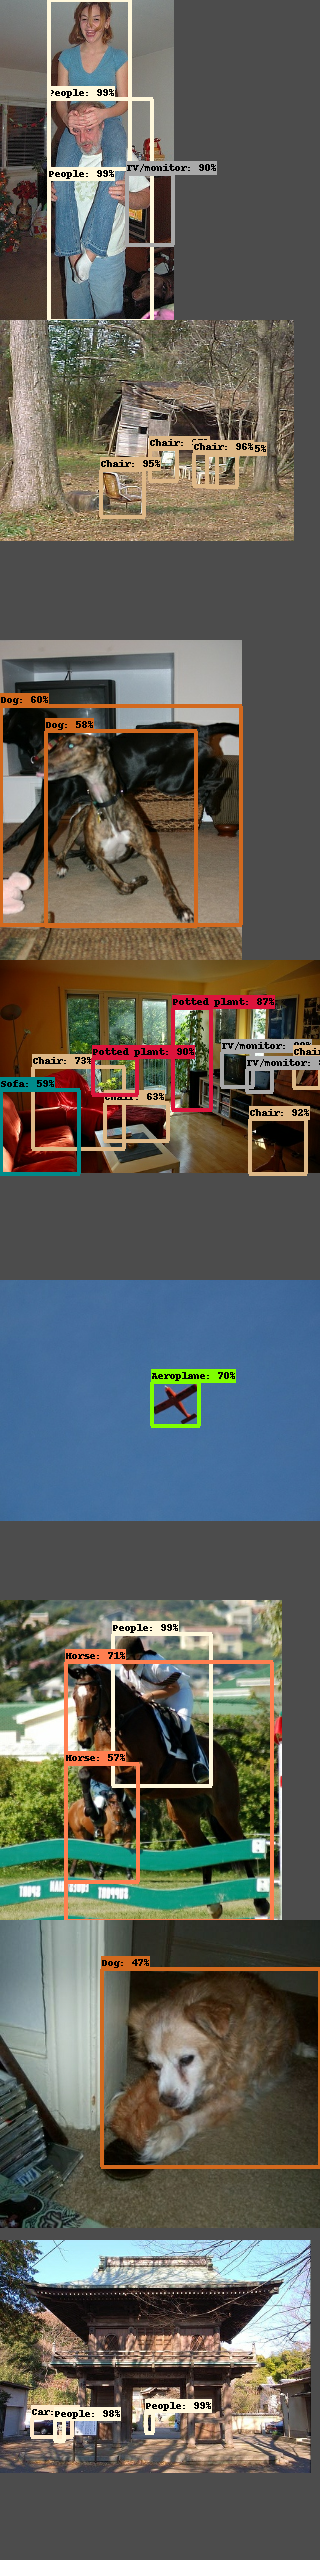

In [ ]:
# Visualization.
im = tf.concat([vis['pred'][i] for i in range(config.train.batch_size)], 0)
Image.fromarray(np.uint8(im.numpy() * 255))